This notebook is an example of using the Particles class in particles.py to read, process, and plot data from .lis files.

In [1]:
from particles import *

plotting_movies = False

if not plotting_movies:
     # WARNING: movie plots will not work in parallel if matplotlib is imported before plot_Ekin_distribution_movie
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

In [2]:
# path to folder containing the .lis files
datapath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2-particles/bin/test021_VL-SR-MPI_2D/joined_lis/'

filenames = sorted(glob.glob(datapath + '*.lis'))

particles = Particles(relativistic=False)
for filename in tqdm(filenames):
    particles.add_snapshot(filename, verbose=False)

100%|██████████| 6668/6668 [00:01<00:00, 3592.27it/s]


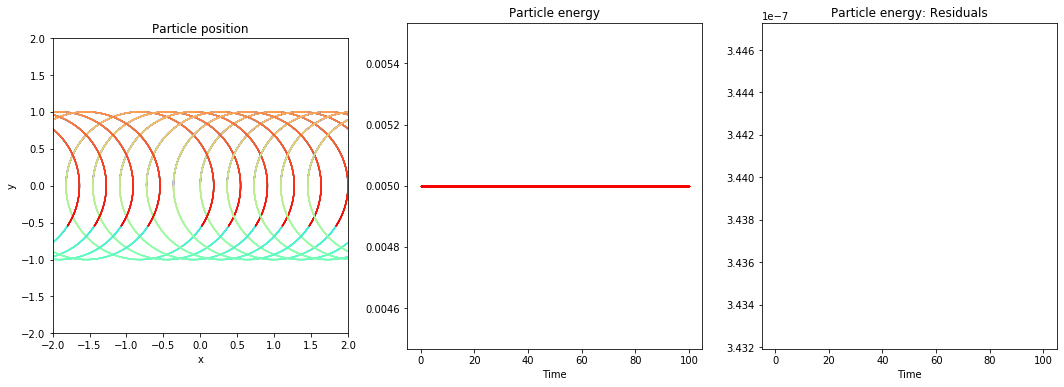

In [3]:
if not plotting_movies:
    
    fig = plt.figure(figsize=(18,6))
    gs = gridspec.GridSpec(1,3)

    plt.subplot(gs[0,0])
    particles.plot_pos2D(plt.gca(), color_by='time')

    particles.update_aux_data()

    plt.subplot(gs[0,1])
    particles.plot_Ekin_vs_time(plt.gca())

    plt.subplot(gs[0,2])
    particles.plot_Ekin_vs_time(plt.gca(), residuals=True)

    plt.show()
    plt.close()

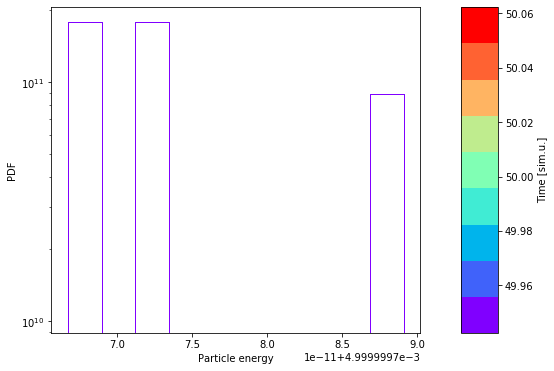

In [4]:
if not plotting_movies:
    fig = plt.figure(figsize=[8,6])
    gs = gridspec.GridSpec(1,2, width_ratios=[1,0.1])

    plt.subplot(gs[0,0])
    particles.plot_Ekin_distribution(plt.gca(), average=False, navg=6660, cax=plt.subplot(gs[0,1]))

    plt.show()
    plt.close()

In [5]:
# WARNING: movie plots will not work in parallel if matplotlib is imported before calling this function!
#  - if plt is loaded, you will (sadly... :/) need to restart the kernel or use a separate session to call this function
if plotting_movies:
    particles.plot_Ekin_distribution_movie(nproc=8, navg=6600, force=True, xmin=0., xmax=0.01)